In [1]:
from IPython.display import clear_output
!pip install qiskit
!pip install qiskit_machine_learning
!pip install pylatexenc
clear_output()

In [2]:
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, TwoLocal
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

In [20]:
class DataReuploading():
    """
    Create the Data Reuploading Classifier ansatz.

    Notes: add QuantumInstance (backend) later.
    """

    def __init__(
        self,
        num_qubits: int | None = None,
        num_features: int | None = None,
        num_layers: int | None = None
    ):
        """
        Args:
            num_qubits: The number of qubits.
            num_features: The number of input features (the dimension of the input data).
            num_layers: The number of layers (N).
        Returns:
            ansatz: A QuantumCircuit object.
        """

        self._num_qubits = num_qubits
        # rounding up the number of features to the nearest integer number that is multiples of 3
        self._num_features = int(np.ceil(num_features/3)*3)
        self._num_layers = num_layers

        self.parameters = ParameterVector(name="θ", length=2*self._num_qubits*self._num_features*self._num_layers)
        self.input_params = ParameterVector(name="x", length=self._num_features)

        qc = QuantumCircuit(self._num_qubits)

        for l in range(self._num_layers):
          for k in range(int(np.ceil(num_features/3))):
            for q in range(self._num_qubits):
              qc.compose(self.rotational_gate_layer(self._num_qubits, q, self.parameters[l*self._num_qubits*int(np.ceil(num_features/3))*2*3 + q*int(np.ceil(num_features/3))*2*3 + k*2*3 : l*self._num_qubits*int(np.ceil(num_features/3))*2*3 + q*int(np.ceil(num_features/3))*2*3 + k*2*3 + 2*3], self.input_params[k*3 : k*3+3]), inplace=True)

          qc.barrier()
          
          # if it's not the last layer, add the entanglement
          if (l+1) != self._num_layers and self._num_qubits != 1:
            qc.compose(self.entanglement_layer(self._num_qubits), inplace=True)
            qc.barrier()

        self.circuit = qc

    def rotational_gate_layer(
        self,
        num_qubits: int | None = None,
        qubit_id: int | None = None,
        trainable_params : ParameterVector | None = None,
        input_params : ParameterVector | None = None
    ):
        """
        Edo
          This is the L layer.
          Args:
              num_qubits: The number of qubits.
              num_features: The number of input features (the dimension of the input data).
          Returns:
              circuit_block: A QuantumCircuit object with ParameterVector as gate's arguments.
        """

        circuit_block = QuantumCircuit(num_qubits)
        circuit_block.rx(trainable_params[0] + trainable_params[3]*input_params[0], qubit_id)
        circuit_block.ry(trainable_params[1] + trainable_params[4]*input_params[1], qubit_id)
        circuit_block.rz(trainable_params[2] + trainable_params[5]*input_params[2], qubit_id)

        return circuit_block



    def entanglement_layer(
        self,
        num_qubits: int | None = None
    ):
        """
        Shivani
          This is the E layer.
          Args:
              num_qubits: The number of qubits.
          Returns:
              circuit_block: A QuantumCircuit object consists of only CZ gates.
        """

        circuit_block = QuantumCircuit(num_qubits)

        # Apply CZ gates between adjacent qubits linearly
        for i in range(num_qubits - 1):
            circuit_block.cz(i, i + 1)


        return circuit_block


    @property
    def num_qubits(self) -> int:
        """Returns the number of qubits used by the ansatz."""
        return self._num_qubits

    @property
    def num_features(self) -> int:
        """Returns the number of features of the input data accepted by the ansatz."""
        return self._num_features

    @property
    def num_layers(self) -> int:
        """Returns the number of layers used by the ansatz."""
        return self._num_layers

# Circle

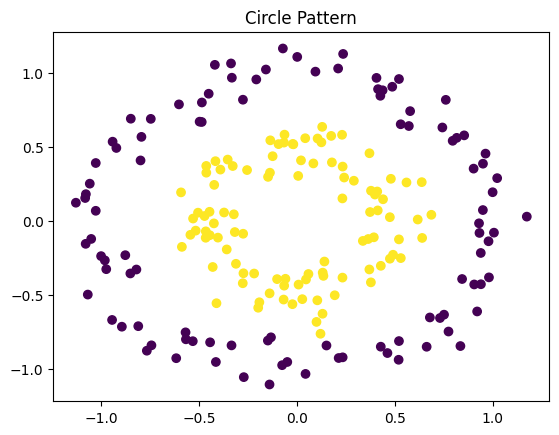

In [65]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

# Generate a dataset with a circle pattern
X_circle, y_circle = make_circles(n_samples=200, noise=0.1, factor=0.5)

# Plot the circle pattern
plt.scatter(X_circle[:, 0], X_circle[:, 1], c=y_circle)
plt.title('Circle Pattern')
plt.show()

In [66]:
# zero padding

X_circle = np.pad(X_circle, ((0, 0), (0, 1)))

# convert to torch Tensors

X_circle = Tensor(X_circle)
y_circle = Tensor(y_circle).reshape(len(y_circle), 1)

# Train-Test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_circle, y_circle, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([160, 3]),
 torch.Size([160, 1]),
 torch.Size([40, 3]),
 torch.Size([40, 1]))

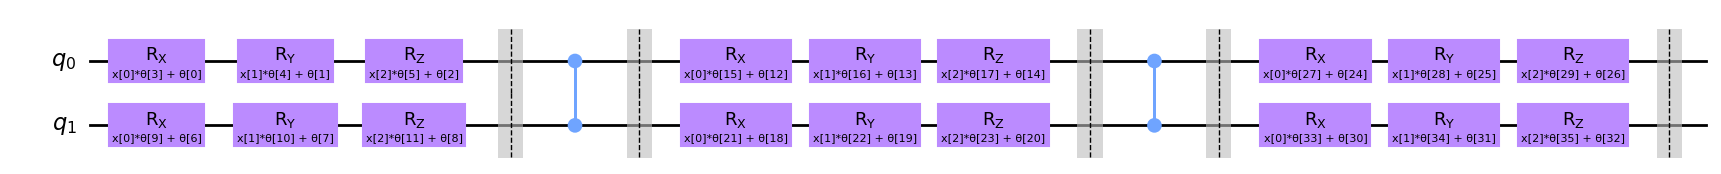

In [72]:
DRC = DataReuploading(num_qubits=2, num_features=2, num_layers=3)
DRC.circuit.draw('mpl')

In [73]:
# Setup QNN
qnn1 = EstimatorQNN(
    circuit=DRC.circuit, input_params=DRC.input_params, weight_params=DRC.parameters
)

# Set up PyTorch module
model1 = TorchConnector(qnn1)

In [74]:
# Test with a single input
model1(X_train[0, :])

tensor([0.7930], grad_fn=<_TorchNNFunctionBackward>)

In [75]:
# Define optimizer and loss
optimizer = LBFGS(model1.parameters())
f_loss = MSELoss(reduction="sum")

# Start training
model1.train()  # set model to training mode


# Note from (https://pytorch.org/docs/stable/optim.html):
# Some optimization algorithms such as LBFGS need to
# reevaluate the function multiple times, so you have to
# pass in a closure that allows them to recompute your model.
# The closure should clear the gradients, compute the loss,
# and return it.
def closure():
    optimizer.zero_grad()  # Initialize/clear gradients
    loss = f_loss(model1(X_train), y_train)  # Evaluate loss function
    loss.backward()  # Backward pass
    print(loss.item())  # Print loss
    return loss


# Run optimizer step4
optimizer.step(closure)

47.603797912597656
26.51201820373535
16.8585205078125
14.21085262298584
12.162906646728516
11.527294158935547
10.723348617553711
10.317514419555664
10.108065605163574
9.91226577758789
9.549140930175781
9.124420166015625
8.772254943847656
8.698047637939453
8.622504234313965
8.57723331451416
8.498326301574707
8.410527229309082
8.288567543029785
8.215283393859863


tensor(47.6038, grad_fn=<MseLossBackward0>)

Accuracy: 0.4


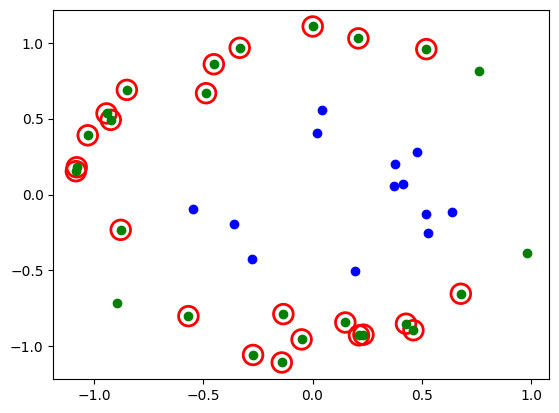

In [77]:
# Evaluate model and compute accuracy
y_predict = []
for x, y_target in zip(X_test, y_test):
    output = model1(Tensor(x))
    y_predict += [np.sign(output.detach().numpy())[0]]

print("Accuracy:", sum(y_predict == y_test.numpy().reshape(-1,)*2-1) / len(y_test))

# Plot results
# red == wrongly classified
for x, y_target, y_p in zip(X_test, y_test.numpy().reshape(-1,)*2-1, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)

plt.show()

In [78]:
y_predict

[1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [79]:
y_test.numpy().reshape(-1,)*2-1

array([ 1., -1., -1.,  1., -1., -1.,  1., -1.,  1., -1., -1.,  1., -1.,
       -1., -1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1.,  1., -1.,
        1.,  1., -1., -1.,  1., -1.,  1., -1., -1., -1., -1., -1.,  1.,
       -1.], dtype=float32)